🔍 Computing dataset mean and std...
📦 Loading dataset with computed normalization...
⚙️ Loading EfficientNet-B0 and ResNet50...
🔎 Extracting dual CNN features...


Extracting Dual Features: 100%|██████████| 677/677 [05:39<00:00,  2.00it/s]


⚖️ Standardizing features...
🧠 Applying supervised UMAP...


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🔀 Splitting into train and test sets...
🤖 Training weighted soft voting ensemble classifier...

✅ Final Accuracy: 99.82%

Classification Report:

               precision    recall  f1-score   support

IR Artificial       1.00      1.00      1.00       317
       Normal       1.00      1.00      1.00       384
OR Artificial       1.00      1.00      1.00       382

     accuracy                           1.00      1083
    macro avg       1.00      1.00      1.00      1083
 weighted avg       1.00      1.00      1.00      1083



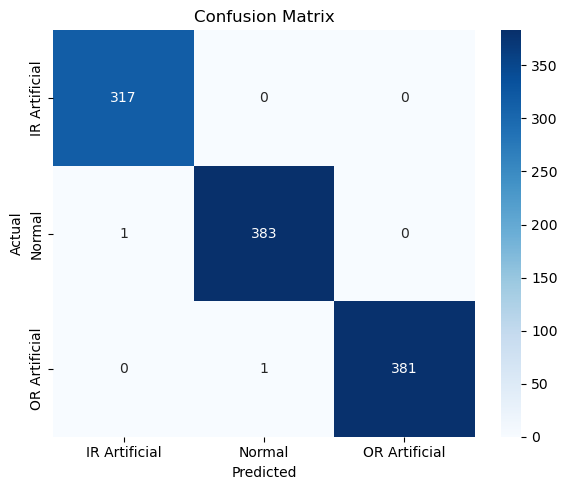

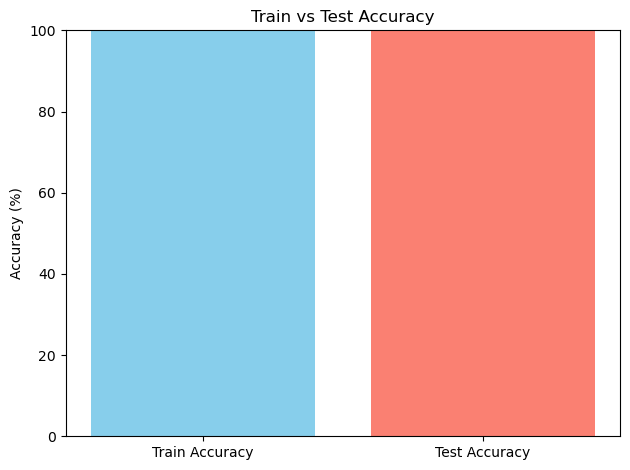

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import numpy as np
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Dataset path
data_path = r"E:\Collaboration Work\With Farooq\Bearings MDPI\Paderborn_all_CWT"

# Step 2: Compute mean and std for custom normalization
print("🔍 Computing dataset mean and std...")
temp_dataset = datasets.ImageFolder(root=data_path, transform=transforms.ToTensor())
temp_loader = DataLoader(temp_dataset, batch_size=32, shuffle=False)

def compute_mean_std(loader):
    mean = 0.
    std = 0.
    total = 0
    for imgs, _ in loader:
        imgs = imgs.view(imgs.size(0), imgs.size(1), -1)
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)
        total += imgs.size(0)
    mean /= total
    std /= total
    return mean, std

mean, std = compute_mean_std(temp_loader)

# Step 3: Reload dataset with custom normalization
print("📦 Loading dataset with computed normalization...")
final_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])
dataset = datasets.ImageFolder(root=data_path, transform=final_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
class_names = dataset.classes
np.save("class_names.npy", class_names)

# Step 4: Load pretrained models
print("⚙️ Loading EfficientNet-B0 and ResNet50...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

effnet = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
effnet.classifier = nn.Identity()
effnet = effnet.to(device).eval()

resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet.fc = nn.Identity()
resnet = resnet.to(device).eval()

# Step 5: Feature extraction
print("🔎 Extracting dual CNN features...")
def extract_dual_features(model1, model2, dataloader):
    features, labels = [], []
    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Extracting Dual Features"):
            x = x.to(device)
            out1 = model1(x)
            out2 = model2(x)
            out = torch.cat((out1, out2), dim=1).cpu().numpy()
            features.append(out)
            labels.append(y.numpy())
    return np.vstack(features), np.concatenate(labels)

features, labels = extract_dual_features(effnet, resnet, dataloader)

# Step 6: Standardize features
print("⚖️ Standardizing features...")
scaler = StandardScaler()
features_std = scaler.fit_transform(features)

# Step 7: Apply UMAP with supervised learning
print("🧠 Applying supervised UMAP...")
reducer = umap.UMAP(n_components=40, n_neighbors=10, min_dist=0.05,
                    target_metric='categorical', random_state=42)
features_umap = reducer.fit_transform(features_std, y=labels)

# Step 8: Train-test split
print("🔀 Splitting into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    features_umap, labels, test_size=0.2, random_state=42, stratify=labels)

# Step 9: Define and train ensemble classifier
print("🤖 Training weighted soft voting ensemble classifier...")
svm = SVC(kernel='poly', degree=3, C=5, probability=True)
rf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=2000, random_state=42)

ensemble = VotingClassifier(estimators=[
    ('svm', svm), ('rf', rf), ('mlp', mlp)
], voting='soft', weights=[3, 1, 3])

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

# Step 10: Evaluation
print("\n✅ Final Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

# Step 11: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Step 12: Accuracy Plot
train_acc = ensemble.score(X_train, y_train)
test_acc = ensemble.score(X_test, y_test)

plt.figure()
plt.bar(['Train Accuracy', 'Test Accuracy'],
        [train_acc * 100, test_acc * 100], color=['skyblue', 'salmon'])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.tight_layout()
plt.show()


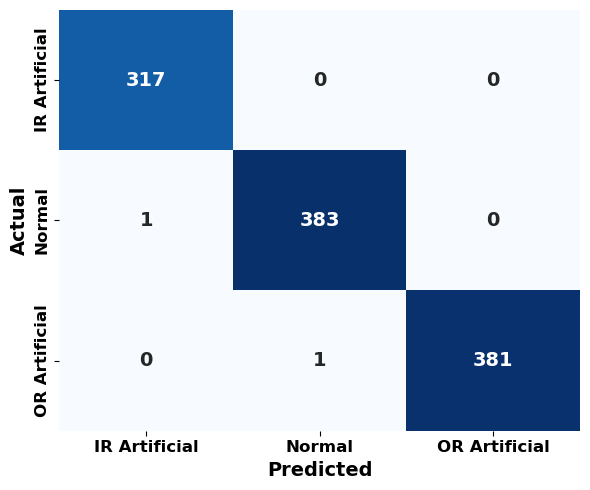

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ensure class_names is loaded from dataset
class_labels_real = class_names  # alias for clarity

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels_real,
            yticklabels=class_labels_real,
            cbar=False,
            annot_kws={"size": 14, "fontweight": "bold"})

# Axis labels and styling
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold', rotation=0)
plt.yticks(fontsize=12, fontweight='bold', rotation=90)

plt.grid(False)
plt.tight_layout()
plt.show()


🧠 Applying Supervised UMAP for better class separation...


c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Muhammad Umar\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


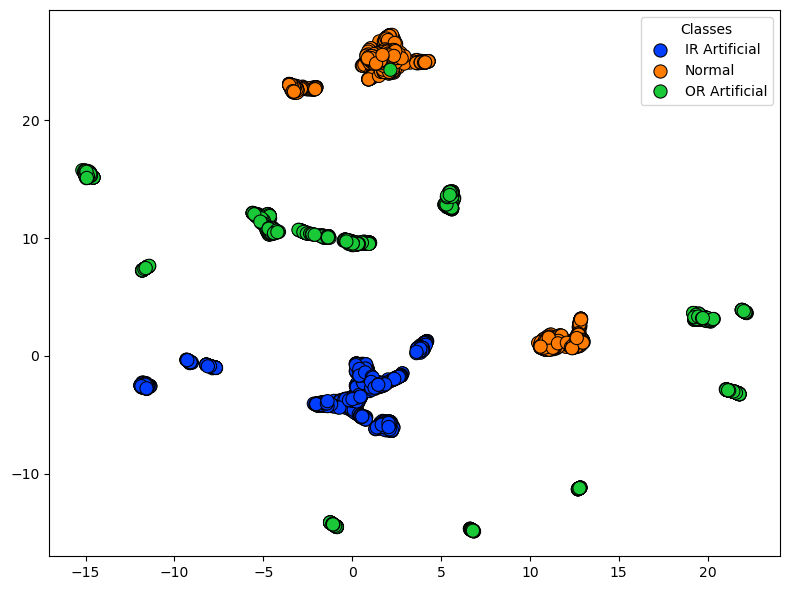

In [11]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

print("🧠 Applying Supervised UMAP for better class separation...")

# Supervised UMAP with 2 components
reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.05,
    target_metric='categorical',
    random_state=42
)
features_umap_2d = reducer.fit_transform(features_std, y=labels)

# Plot UMAP results
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=features_umap_2d[:, 0],
    y=features_umap_2d[:, 1],
    hue=[class_names[label] for label in labels],
    palette="bright",
    s=90, alpha=1, edgecolor='k'
)

plt.legend(loc='best', fontsize=10, title="Classes")
plt.tight_layout()
plt.show()


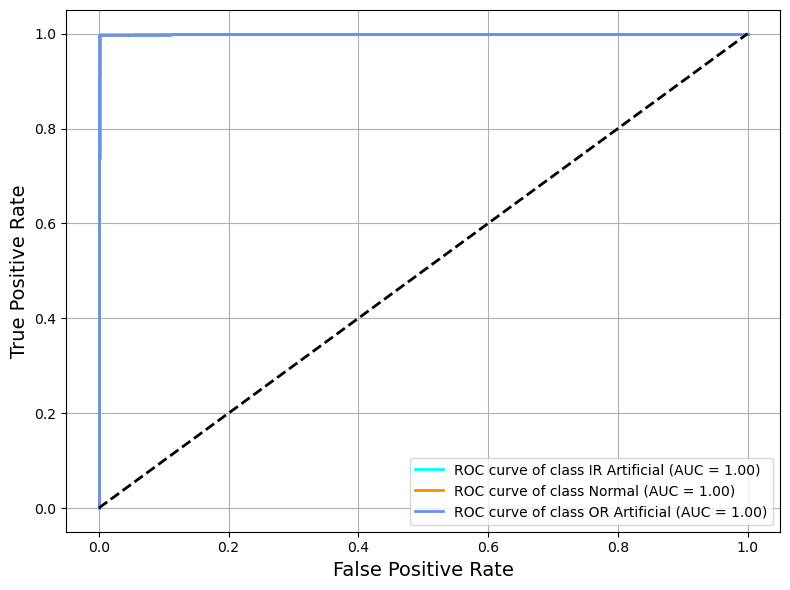

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from numpy import interp
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(labels))
n_classes = y_test_bin.shape[1]

# Train again using OneVsRest wrapper
ensemble_ovr = OneVsRestClassifier(ensemble)
ensemble_ovr.fit(X_train, label_binarize(y_train, classes=np.unique(labels)))
y_score = ensemble_ovr.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'
                   ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()
